Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [196]:
import os

import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [197]:
RANDOM_SEED = 42

In [198]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [199]:
templ = pd.read_csv('data/df_moscow_all_upd.csv')
templ.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,67.0349,1.3200,20155.000000,1.0538,0,0,-1
1,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,58.3529,1.2527,21239.338735,1.0252,0,0,-1
2,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,62.7078,1.2218,21774.570269,1.0427,0,0,-1
3,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,64.7362,1.1718,22704.345558,1.0305,0,0,-1
4,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,72.1464,1.1371,23396.829332,1.0491,0,0,-1


In [200]:
dollar = templ.groupby('year')['currency'].mean().to_dict()
dollar

{2011: 29.387400000000003,
 2012: 31.093000000000004,
 2013: 31.848000000000003,
 2014: 38.4217,
 2015: 60.9579,
 2016: 67.0349,
 2017: 58.3529,
 2018: 62.7078,
 2019: 64.7362,
 2020: 72.1464,
 2021: 73.6541}

In [201]:
data = pd.read_csv('data/data-2012.csv')
curr_ind = [c for c in data.columns if c.startswith('ind_') and c.endswith('3')]
data['year'] = 2012

In [202]:
files = [f for f in os.listdir('data/') if f.startswith('data-')]
files.remove('data-2012.csv')
for file in files:
    data_part = pd.read_csv(f'data/{file}')
    data_part['year'] = int(file[5:9])
    data = pd.concat([data, data_part])
data = data[['org_inn', 'year', 'okved', 'name','subject_rf', 'type', 'okopf', 'okfs', 'measure'] + curr_ind]
data.columns = ['inn', 'year', 'main_okved', 'name', 'subject_rf', 'type', 'okopf', 'okfs', 'measure'] + [c[:-1]for c in curr_ind]
data.head()

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,ind_6321,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400
0,4824053865,2012,72.2,"Общество с ограниченной ответственностью ""Бизнес - технологии""",48.0,1,65,16,384,0,...,0,0,0,0,0,0,0,0,0,0
1,2508090520,2012,63.11,"Закрытое акционерное общество ""Находкинский Международный Терминал""",NaN,2,67,34,384,0,...,0,0,0,0,0,0,0,0,0,0
2,7802794520,2012,63.12,"Общество с ограниченной ответственностью ""Волховнефтепродукт""",78.0,1,65,16,384,0,...,0,0,0,0,0,0,0,0,0,0
3,7717029782,2012,55.1,"ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГОСТИНИЦА ""ЗВЕЗДНАЯ""",77.0,2,47,34,384,0,...,0,0,0,0,0,0,0,0,0,0
4,7723841914,2012,72.2,"Общество с ограниченной ответственностью ""Э-КОМ РУС""",NaN,2,65,34,384,21,...,0,0,0,0,0,0,0,0,0,0


In [203]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505111 entries, 0 to 149789
Data columns (total 140 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    inn         505111 non-null  int64  
 1    year        505111 non-null  int64  
 2    main_okved  505111 non-null  object 
 3    name        505111 non-null  object 
 4    subject_rf  232389 non-null  float64
 5    type        505111 non-null  int64  
 6    okopf       505111 non-null  int64  
 7    okfs        505111 non-null  int64  
 8    measure     505111 non-null  int64  
 9    ind_1110    505111 non-null  int64  
 10   ind_1120    505111 non-null  int64  
 11   ind_1130    505111 non-null  int64  
 12   ind_1140    505111 non-null  int64  
 13   ind_1150    505111 non-null  int64  
 14   ind_1160    505111 non-null  int64  
 15   ind_1170    505111 non-null  int64  
 16   ind_1180    505111 non-null  int64  
 17   ind_1190    505111 non-null  int64  
 18   ind_1100    505111 non

In [204]:
# Сразу типмизируем, чтоб не путаться
data['inn'] = data['inn'].astype(str)
data['main_okved'] = data['main_okved'].astype(str)
data['name'] = data['name'].astype(str)
data['type'] = data['type'].astype(int)
data['year'] = data['year'].astype(int)
data[[c for c in data.columns if c.startswith('ind_')]] = data[[c for c in data.columns if c.startswith('ind_')]].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505111 entries, 0 to 149789
Data columns (total 140 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    inn         505111 non-null  object 
 1    year        505111 non-null  int64  
 2    main_okved  505111 non-null  object 
 3    name        505111 non-null  object 
 4    subject_rf  232389 non-null  float64
 5    type        505111 non-null  int64  
 6    okopf       505111 non-null  int64  
 7    okfs        505111 non-null  int64  
 8    measure     505111 non-null  int64  
 9    ind_1110    505111 non-null  float64
 10   ind_1120    505111 non-null  float64
 11   ind_1130    505111 non-null  float64
 12   ind_1140    505111 non-null  float64
 13   ind_1150    505111 non-null  float64
 14   ind_1160    505111 non-null  float64
 15   ind_1170    505111 non-null  float64
 16   ind_1180    505111 non-null  float64
 17   ind_1190    505111 non-null  float64
 18   ind_1100    505111 non

In [205]:
# for col in [c for c in data.columns if c.startswith('ind_')]:
#     data[col] = data[col] / data['currency']

In [206]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
additional_features.remove('ind_2400')
investments = data.sort_values(by=['inn', 'year']).groupby('inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')
data = data.join(investments, on=['inn'])
data[['inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,inn,year,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
0,4824053865,2012,2012,214.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2508090520,2012,2012,152150.0,0.0,0.0,0.0,0.0,19074.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7802794520,2012,2012,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7717029782,2012,2012,101278.0,0.0,0.0,0.0,0.0,41708.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7723841914,2012,2012,24336.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
data.loc[data['inv_sum'] <= 0, ['inv_sum', 'inn', 'year']]

,inv_sum,inn,year
104,0.0,2722015426,2012
222,-42.0,6455047211,2012
244,0.0,7704821510,2012
375,0.0,7722163342,2012
564,0.0,7724839587,2012
...,...,...,...
149784,0.0,7802850573,2018
149786,0.0,4227001704,2018
149787,0.0,6324023922,2018
149788,0.0,4704032609,2018


In [208]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['inn', 'year']).groupby('inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['inn', 'year']).head()

,inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
5477,1001002620,2013,24047.0,24047.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,0.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,96.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,4348.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,1006.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
data.sort_values(by=['inn', 'year']).groupby('inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
inn,,,,,,,,,,,,,,,,,,,,,
1001002620,2015,8933.0,0.0,2013,40522.0,0.0,0.0,0.0,0.0,4819.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001004137,2017,-116.0,0.0,2017,101.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001004176,2016,0.0,-495.0,2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001004377,2018,31.0,26.0,2016,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001007610,2018,1897.0,712.0,2016,106.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [211]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result
3197,7704799590,2012,72.2,"Общество с ограниченной ответственностью ""Эксентекс""",77.0,2,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4683.0,165021.0
53522,2320249230,2017,56.10.1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""РЕСТОРАТОР""",23.0,1,12300,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1195.0


In [212]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['inn', 'year']).groupby('inn').last(),
           data[data['result'] <= 0].sort_values(by=['inn', 'year']).groupby('inn').first()]).reset_index()
temp = temp.sort_values(by=['inn', 'year']).groupby(['inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result
227249,8602998278,2016,85.42,"Частное образовательное учреждение дополнительного профессионального образования ""Сервис нефтяного комплекса""",NaN,0,71,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,863.0,442.0,663.0,-221.0
120848,6163138831,2017,59.20,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ХОЛИ ЛЭНД МЬЮЗИК""",NaN,1,12300,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,341.0,-259.0


In [213]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result,target
153898,7415096694,2017,62.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МАТРИЦА""",74.0,2,12300,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
185503,7719847423,2016,58.14,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ВЕСТМЭН МЕНЕДЖМЕНТ""",NaN,2,12165,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,790.0,-417.0,0


In [214]:
temp[temp['type'] == 0]

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result,target
14,1001015192,2018,94.99,АССОЦИАЦИЯ УПРАВЛЯЮЩИХ ОРГАНИЗАЦИЙ РЕСПУБЛИКИ КАРЕЛИЯ,NaN,0,12300,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,18.0,1335.0,0.0,1335.0,-1
17,1001015481,2018,94.99,"КАРЕЛЬСКАЯ РЕГИОНАЛЬНАЯ МОЛОДЕЖНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ ""ПЕДАГОГИЧЕСКИЙ ОТРЯД ""ПАРАЛЛЕЛИ""",NaN,0,20200,53,384,0.0,...,0.0,0.0,0.0,0.0,0.0,34.0,0.0,125.0,42.0,-1
21,1001015700,2016,94.99,"КАРЕЛЬСКАЯ РЕГИОНАЛЬНАЯ ОБЩЕСТВЕННАЯ МОЛОДЕЖНАЯ ОРГАНИЗАЦИЯ ""МОЛОДЕЖНЫЕ ИНИЦИАТИВЫ""",NaN,0,83,15,384,0.0,...,0.0,0.0,0.0,0.0,0.0,329.0,412.0,20435.0,-20023.0,0
22,1001015717,2016,94.99,"РЕГИОНАЛЬНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ ""ФЕДЕРАЦИЯ ХОККЕЯ РЕСПУБЛИКИ КАРЕЛИЯ""",NaN,0,83,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,1657.0,17.0,9066.0,-8778.0,0
35,1001016750,2016,94.99,Карельская региональная общественная организация ветеранов органов внутренних дел и внутренних войск Карелии,NaN,0,83,53,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8621.0,-5135.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237262,9729020731,2017,85.42,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ДОПОЛНИТЕЛЬНОГО ПРОФЕССИОНАЛЬНОГО ОБРАЗОВАНИЯ «ОБРАЗОВАНИЕ – РУССКОЕ СЛОВО»,NaN,0,71400,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,350.0,589.0,-193.0,1
237300,9729031130,2017,90.01,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР ДЕТСКОЙ ПЕСНИ СОЛНЫШКО""",NaN,0,71400,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,229.0,17.0,4342.0,-4322.0,0
237469,9729129351,2017,94.99,"РЕГИОНАЛЬНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ ЗАЩИТЫ ПРАВ ПОТРЕБИТЕЛЕЙ И ПРЕДПРИНИМАТЕЛЕЙ ""ПОТРЕБИТЕЛЬСКАЯ ИНСПЕКЦИЯ""",NaN,0,20200,53,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0
237534,9729171441,2018,85.41,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ПО РАЗВИТИЮ ОБРАЗОВАТЕЛЬНЫХ ТЕХНОЛОГИЙ «ЭДДВА»,NaN,0,71400,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,9147.0,2867.0,0.0,3144.0,-1


In [215]:
# В рабочий набор берем только коммерческие организации
work_df = temp.loc[temp['type'] > 0, ['inn', 'main_okved', 'inv_sum', 'target', 'subject_rf', 'year'] + ['inv_' + x for x in additional_features]]
work_df.head()

,inn,main_okved,inv_sum,target,subject_rf,year,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
0,1001002620,63.11,40522.0,-1,NaN,2015,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001004137,56.10.1,101.0,-1,NaN,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001004176,85.41,0.0,-1,10.0,2016,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001004377,91.02,71.0,0,NaN,2016,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001007610,93.2,106.0,0,10.0,2016,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

In [216]:
for f in work_df.columns:
    first_look(work_df[f])

--------------------------------------------------------------------------------
Название: inn
Тип данных: <class 'numpy.object_'>
Количество значений: 228688
Количество уникальных значений: 228688
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count         228688
unique        228688
top       1001002620
freq               1
Name: inn, dtype: object
Топ 10 уникальных значений:
1001002620    1
7604283403    1
7604280427    1
7604280956    1
7604281396    1
7604281639    1
7604281773    1
7604282022    1
7604282248    1
7604282400    1
Name: inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: main_okved
Тип данных: <class 'numpy.object_'>
Количество значений: 228688
Количество уникальных значений: 68
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     228688
unique        68
top        94.99
freq       45403

### Feature engineering

In [217]:
work_df = work_df[work_df['inv_sum'] > 0]

<AxesSubplot:>

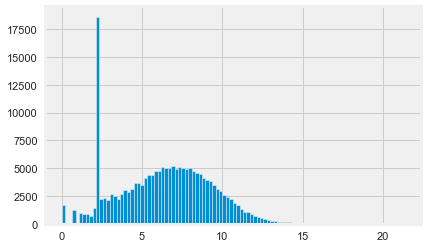

In [218]:
np.log(work_df['inv_sum']).hist(bins=100)

In [219]:
work_df['inv_sum'] = np.log(work_df['inv_sum'])

In [220]:
work_df['subject_rf']= work_df['subject_rf'].astype(str)
work_df['subject_rf'].fillna('99', inplace=True)

In [221]:
for feature in ['inv_sum'] + ['inv_' + x for x in additional_features]:
    work_df[feature] = work_df.apply(lambda row: row[feature] / dollar[row['year']], axis=1)

### Первая модель - LR

In [222]:
# Формируем X
# Масштабируем числовые признаки
X = pd.DataFrame([], index=work_df.index)
X[['inv_sum'] + ['inv_' + x for x in additional_features]] = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X.sample(2)

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
214768,-1.679265,-0.003285,-0.012973,-0.004802,-0.003931,-0.007064,-0.007245,-0.003456,-0.017822,-0.012837,...,-0.016836,-0.010015,-0.013738,-0.017994,-0.006128,-0.015585,-0.008794,-0.005085,-0.010761,-0.01186
98057,-0.342204,-0.003285,-0.012973,-0.004802,-0.003931,-0.007064,-0.007245,-0.003456,-0.017822,-0.012837,...,-0.016836,-0.010015,-0.013738,-0.017994,-0.006128,-0.015585,-0.008794,-0.005085,-0.010761,-0.01186


In [223]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'subject_rf']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'subject_rf']]).astype(int)
X.sample(2)

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,x1_79.0,x1_8.0,x1_83.0,x1_86.0,x1_87.0,x1_89.0,x1_9.0,x1_91.0,x1_92.0,x1_nan
171311,1.118224,-0.003285,-0.012973,-0.004802,-0.003931,-0.007064,-0.007245,-0.003456,-0.017822,-0.012837,...,0,0,0,0,0,0,0,0,0,0
180397,0.767969,-0.003285,-0.012973,-0.004802,-0.003931,-0.006964,-0.007245,-0.003456,-0.017822,-0.012837,...,0,0,0,0,0,0,0,0,0,1


In [224]:
# В таргет берем только признак окупиться/не окупится
y = (work_df['target'] != -1).astype(int)
y.unique()

array([0, 1])

In [225]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((185348, 283), (185348,), (148278, 283), (148278,), (37070, 283), (37070,))

In [226]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7191364961797271

В принципе результат не плохой - можно работать дальше

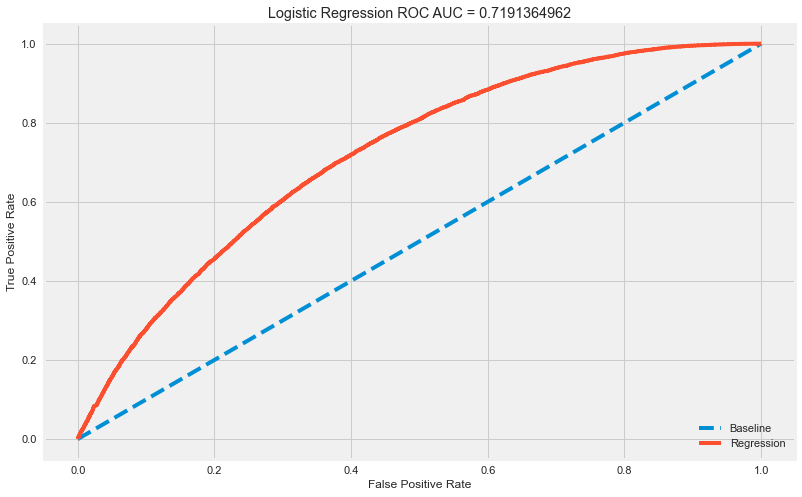

In [227]:
show_roc_auc(y_valid, y_prob[:, 1])

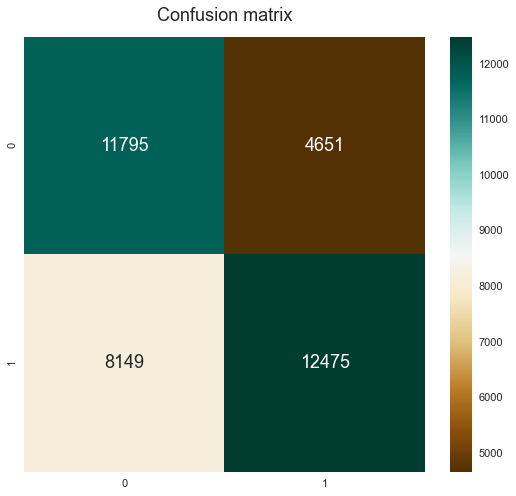

In [228]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

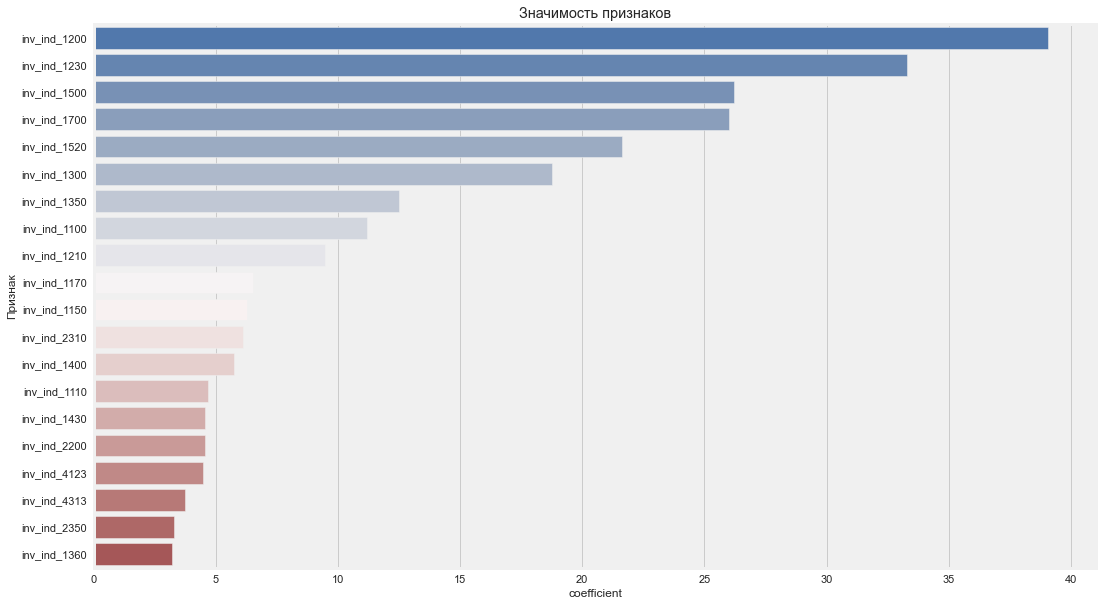

In [229]:
show_lr_Importance(lr, X.columns)

In [230]:
# По замечаниям - проверка на переобучение
y_prob = lr.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.7205235448848014

### LGBMClassifier

In [231]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.8411352938525665

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

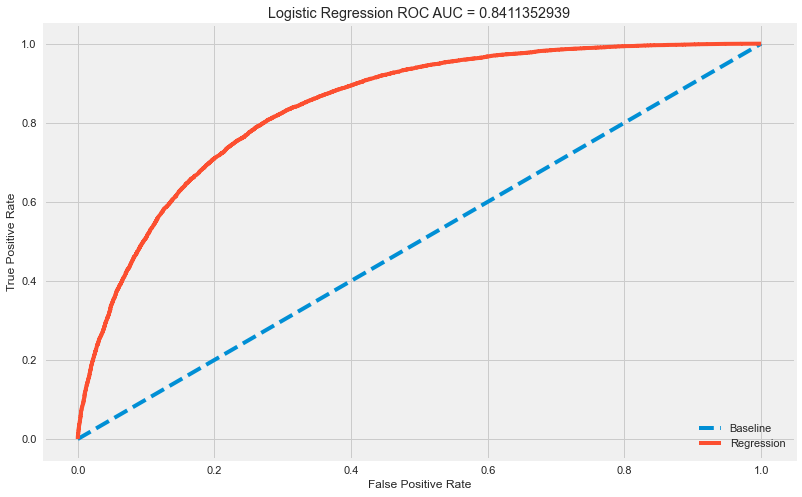

In [232]:
show_roc_auc(y_valid, y_prob[:, 1])

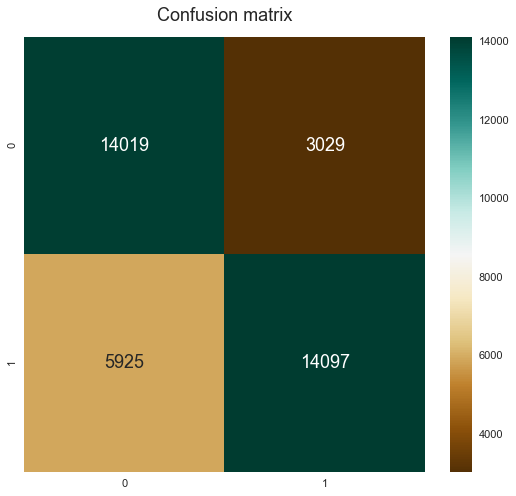

In [233]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

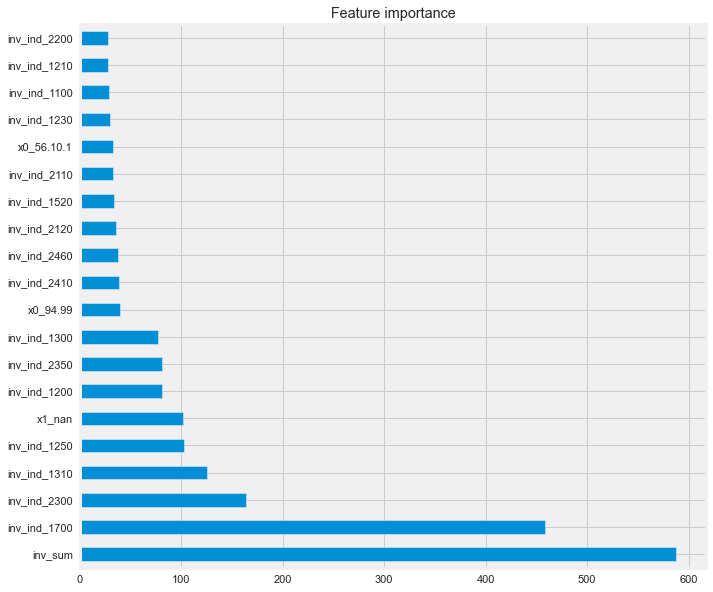

In [234]:
plot_feature_importances(model.feature_importances_, X.columns)

In [235]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.8490508954954645

### Предсказание срока выхода из убытков

In [262]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
features = ['inv_sum']
#features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[features] = preprocessing.StandardScaler().fit_transform(work_df[features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'subject_rf']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'subject_rf']]).astype(int)
y = work_df['target']
X.shape, y.shape

((185348, 154), (185348,))

In [263]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((185348, 154), (185348,), (148278, 154), (148278,), (37070, 154), (37070,))

In [264]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, multi_class='ovr', average='weighted')

0.702349370386851

In [265]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob, multi_class='ovr', average='weighted')

0.7135688173224387

In [267]:
cross_val_score(model, X, y, cv=3, scoring='roc_auc_ovo_weighted')

array([0.74981145, 0.66475601, 0.68470618])

На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

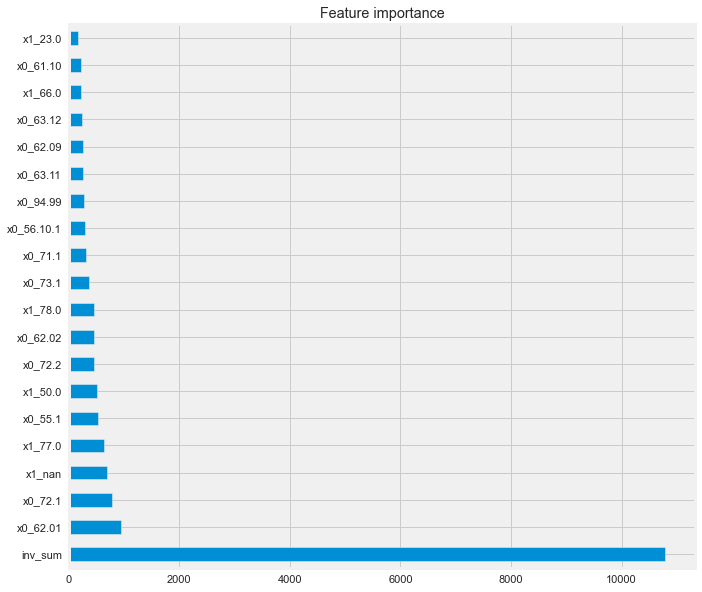

In [253]:
plot_feature_importances(model.feature_importances_, X.columns)

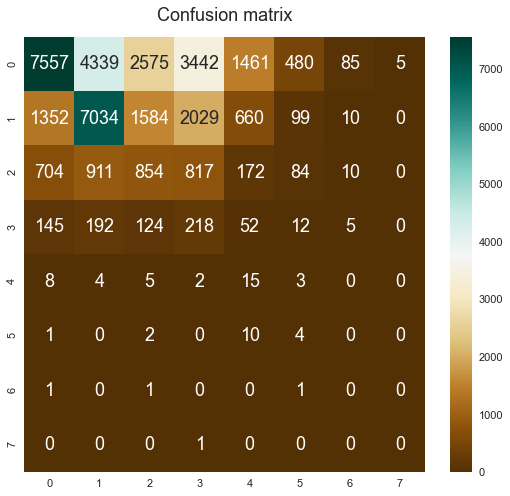

In [256]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [257]:
list(zip(y_pred, y_valid))[100:110]

[(2, -1),
 (2, 1),
 (2, -1),
 (2, -1),
 (2, 1),
 (0, 0),
 (0, -1),
 (0, -1),
 (-1, -1),
 (-1, -1)]

In [258]:
model = LGBMRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.mean_absolute_error(y_valid, y_pred)

0.5639746297091971

In [259]:
list(zip(np.round(y_pred), y_valid))[100:110]

[(-0.0, -1),
 (-0.0, 1),
 (-0.0, -1),
 (-0.0, -1),
 (-0.0, 1),
 (-0.0, 0),
 (-0.0, -1),
 (-0.0, -1),
 (-1.0, -1),
 (-1.0, -1)]

In [260]:
np.unique(np.round(y_pred), return_counts=True)

(array([-1., -0.]), array([11609, 25461]))

In [261]:
np.unique(np.round(y_valid), return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6]),
 array([19944, 12768,  3552,   748,    37,    17,     3,     1]))